# Transformer






In [52]:

# Remember to login to wandb!
import sys
import os 
import torch
import matplotlib.pyplot as plt
import copy 
import numpy as np
import gc
import itertools
# Append module directory for imports
parent_dir = os.path.expanduser('../eigenestimation/eigenestimation')

from eigenestimation.evaluation.networks import DrawNeuralNetwork
from eigenestimation.eigenmodel.eigenmodel import EigenModel
from eigenestimation.utils.loss import MSELoss
from eigenestimation.utils.uniform_models import ZeroOutput
from eigenestimation.toy_models.data import GenerateTMSInputs
from eigenestimation.toy_models.parallel_serial_network import CustomMLP
from torch import Tensor
import einops

from eigenestimation.utils.loss import MSELoss, MSEVectorLoss, KLDivergenceFlattenOverTokensLoss


import figure_names
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate
from torch.utils.data import DataLoader


## Set up

In [112]:
eigenmodel_path = f"../outputs/eigenmodels/tinystories-8M.pt"
eigenmodel = torch.load(eigenmodel_path)['model']
tokenizer = eigenmodel.model.tokenizer
frac_activated = torch.load(eigenmodel_path)['frac_activated']


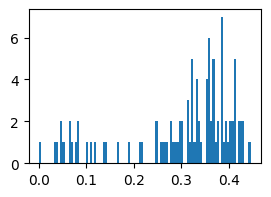

In [109]:
plt.figure(figsize=(3, 2))
plt.hist(frac_activated.detach().cpu().numpy(), bins=100)
plt.show()

In [110]:
for i in eigenmodel.low_rank_decode.values(): 
    for ii in i: 
        ii.requires_grad_(False)
for i in eigenmodel.low_rank_encode.values(): 
    for ii in i: 
        ii.requires_grad_(False)


In [56]:
# Load tinystories data
token_length = 16
dataset = load_dataset('roneneldan/TinyStories', split="validation[:1%]")
X_train = tokenize_and_concatenate(dataset, tokenizer, max_length = token_length, add_bos_token=False)['tokens']
# Permute
X_transformer = X_train[torch.randperm(len(X_train)), :][:1000]
del X_train
del dataset


In [113]:
circuit_vals = []
X_ordered = []
iters = 5
n_subnetworks = eigenmodel.n_features

gc.collect()
torch.cuda.empty_cache()
for X_batch in DataLoader(X_transformer[:100], batch_size=8, shuffle=True):
    X_ordered.append(X_batch)
        # Compute gradients many times and take the average
    each_circuit_val = torch.zeros(X_batch.shape[0], n_subnetworks).to('cuda')
    for _ in range(iters):
        grads = eigenmodel.compute_gradients(X_batch.to('cuda'))
        each_circuit_val = each_circuit_val + (eigenmodel(grads))[:,:n_subnetworks]
        gc.collect()
        torch.cuda.empty_cache()
    circuit_vals.append(each_circuit_val.view(X_batch.shape[0], n_subnetworks))
circuit_vals = torch.concat(circuit_vals, dim=0)/iters
X_ordered = torch.concat(X_ordered, dim=0)

RuntimeError: The size of tensor a (8) must match the size of tensor b (128) at non-singleton dimension 0

In [16]:
token_eigenmodel = copy.deepcopy(eigenmodel)
token_eigenmodel.loss = KLDivergenceFlattenOverTokensLoss()

In [41]:
import torch

bold_idx = tokenizer.encode('***')

for i in circuit_vals.mean(dim=0).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs_vals.flatten().argsort(descending=True)[:5]
    
    # Convert the flat indices back to (b, t) indices
    #top_b, top_t = torch.div(top_indices, token_length, #rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_indices]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    for j in range(len(top_indices)):
        sample_idx = top_indices[j].item()
        tokens = X_ordered[sample_idx]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')




---- Feature 89 ---- Activation: 0.490
 leaves under her feet and tried to climb the icy hill again.=newline==newline=This time, Roxy didn't slip. She climbed and climbed until she reached the --> 3.75
. He did not take the shell from Mia. He found it in the sand. He did not want to make Mia angry.=newline==newline="No, Mia --> 2.57
Ben smiled and said, "Thank you, Mia. You are my sister. I love you too."Tom was a cat who liked to play outside. He --> 2.37
able friend to all the animals. He would stand by them and help them when they needed it. Everyone liked Sam because he was kind and strong.=newline==newline= --> 2.23
 them broke and spilled on the floor.=newline==newline="Oh no!" Tom and Anna said. They were scared. They heard their mom coming.=newline==newline=" --> 2.20


---- Feature 51 ---- Activation: 0.456
 farmer heard the cow. He wanted to help. So, he got another cow to be friends with the sad cow. The sad cow was happy now. They --> 2.60
 Lily's mom asked her if she wan

In [118]:
circuit_vals = []
X_ordered = []
iters = 10
n_subnetworks = eigenmodel.n_features

gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    for X_batch in DataLoader(X_transformer[:1000].to('cuda'), batch_size=8, shuffle=True):
        X_ordered.append(X_batch)
        # Compute gradients many times and take the average
        each_circuit_val = torch.zeros(X_batch.shape[0]*X_batch.shape[1], n_subnetworks).to('cuda')
        for _ in range(iters):
            grads = eigenmodel.compute_gradients(X_batch)
            each_circuit_val = each_circuit_val + abs(eigenmodel(grads))[:,:n_subnetworks]
            gc.collect()
            torch.cuda.empty_cache()
        circuit_vals.append(each_circuit_val.view(X_batch.shape[0], X_batch.shape[1], n_subnetworks))
    circuit_vals = torch.concat(circuit_vals, dim=0)/iters
    X_ordered = torch.concat(X_ordered, dim=0)

In [120]:
import torch

bold_idx = tokenizer.encode('***')

for i in circuit_vals.mean(dim=[0,1]).argsort(descending=True):
    if frac_activated[i] < .005:
        continue
    if frac_activated[i] > .5:
        continue
    
    # Get the absolute values for feature i
    abs_vals = (circuit_vals[..., i])

    # Find the top 5 (b, t) indices for feature i
    top_indices = abs(abs_vals).flatten().argsort(descending=True)
    
    # Convert the flat indices back to (b, t) indices
    top_b, top_t = torch.div(top_indices, token_length, rounding_mode='floor'), top_indices % token_length

    # Get the corresponding top values
    top_values = abs_vals[top_b, top_t]

    print(f'\n\n---- Feature {i} ---- Activation: {frac_activated[i]:.3f}')
    sample_idxs_so_far = []
    for j in range(len(top_indices)):
        if top_b[j].item() in sample_idxs_so_far:
            continue
        if len(sample_idxs_so_far) >= 5:
            break
        sample_idxs_so_far.append(top_b[j].item())
        sample_idx = top_b[j].item()
        token_idx = top_t[j].item()
        tokens = X_ordered[sample_idx]
        tokens = tokens[:(token_idx+1)]
        sentence = tokenizer.decode(tokens.long())
        sentence = sentence.replace('\n', '=newline=')
        print(sentence, '-->', f'{top_values[j].item():.2f}')




---- Feature 41 ---- Activation: 0.412
 Ben said.=newline= --> 28.08
=newline="No, go away. You are annoying," Lily said.=newline= --> 24.40
 and he fell in.=newline= --> 22.21
 and slippery, and they could see fish and plants under the ice.=newline= --> 21.56
 too. Do you want to play with me?"=newline==newline= --> 21.22


---- Feature 87 ---- Activation: 0.489
 big, hairy rabbit named --> 24.79
 Lily. --> 20.80
 okay, Lily. The sunset will come again tomorrow." Lily's mommy was --> 20.23
 tried again and again to squeeze the tap, but still no --> -19.83
 sorry for him. She said, --> 18.37


---- Feature 68 ---- Activation: 0.416
 Ben said.=newline==newline="Hi, Ben. Nice to meet --> 16.26
 try the bread. It --> -15.99
 big, hairy rabbit named --> -15.21
 clouds. They saw --> 15.20
 They  --> 14.30


---- Feature 42 ---- Activation: 0.410
 wet. He saw the stick, and grabbed it. Lily pulled him out of --> 20.45
 He loved to play with his ball in the --> 17.93
 sorry for him. She sai

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-8M')
for n,p in model.named_parameters(): print(n, p.shape, p.numel())

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/112M [00:00<?, ?B/s]

transformer.wte.weight torch.Size([50257, 256]) 12865792
transformer.wpe.weight torch.Size([2048, 256]) 524288
transformer.h.0.ln_1.weight torch.Size([256]) 256
transformer.h.0.ln_1.bias torch.Size([256]) 256
transformer.h.0.attn.attention.k_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.v_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.q_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.out_proj.weight torch.Size([256, 256]) 65536
transformer.h.0.attn.attention.out_proj.bias torch.Size([256]) 256
transformer.h.0.ln_2.weight torch.Size([256]) 256
transformer.h.0.ln_2.bias torch.Size([256]) 256
transformer.h.0.mlp.c_fc.weight torch.Size([1024, 256]) 262144
transformer.h.0.mlp.c_fc.bias torch.Size([1024]) 1024
transformer.h.0.mlp.c_proj.weight torch.Size([256, 1024]) 262144
transformer.h.0.mlp.c_proj.bias torch.Size([256]) 256
transformer.h.1.ln_1.weight torch.Size([256]) 256
transformer.h.1.ln_1.bias torch.Size([256]

model.safetensors:   0%|          | 0.00/112M [00:00<?, ?B/s]